In [1]:
from utils.models import *

In [2]:
wti = load('data/WTI.csv').pct_change().dropna()
c1 = clean_series('contract_1', wti)
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

In [3]:
kf = KF().run('contract_1', 'VIX', c1.join(vix_shock).dropna()).cumsum(axis=1)

<AxesSubplot:>

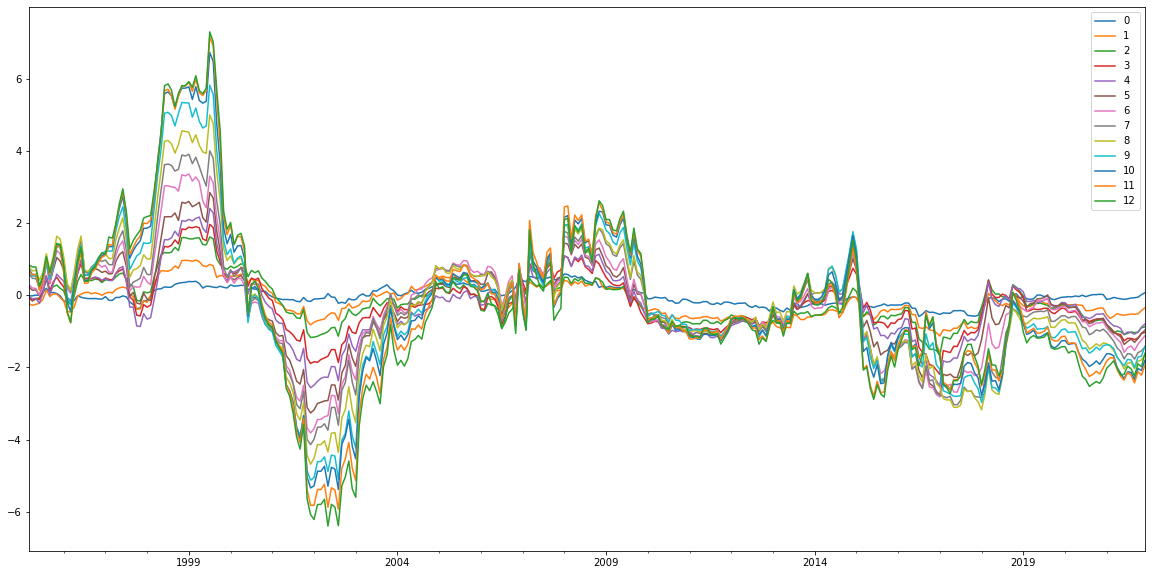

In [4]:
kf.plot(figsize=(20, 10))

<AxesSubplot:>

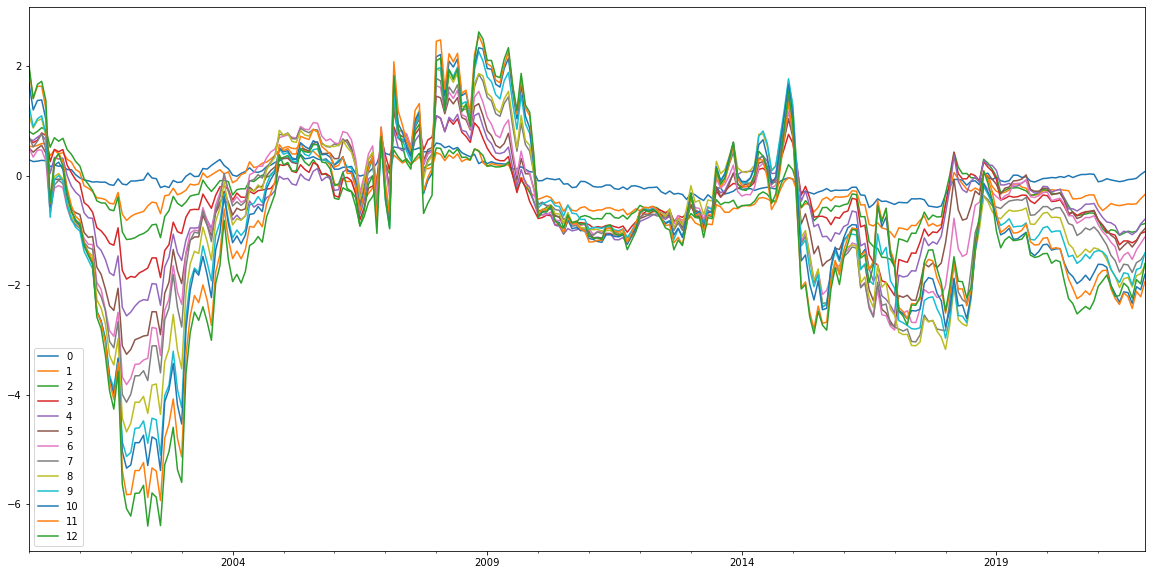

In [5]:
kf.loc['2000':].plot(figsize=(20, 10))

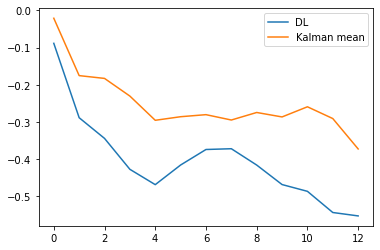

In [7]:
plt.plot(np.cumsum(DL('contract_1', 'VIX', c1.join(vix_shock).dropna()).model.params[1:]), label='DL')
plt.plot(kf.mean(), label='Kalman mean')
plt.legend()

In [8]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

In [9]:
kf2 = KF().run('contract_1', 'GPRI', c1.join(gpr_shock).dropna()).cumsum(axis=1)

<AxesSubplot:>

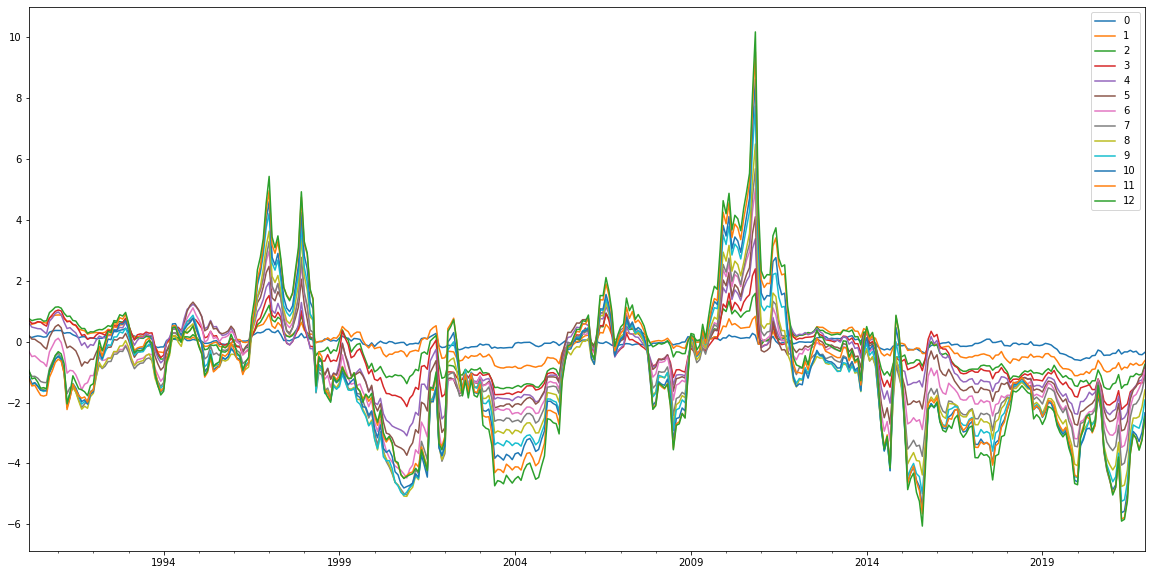

In [10]:
kf2.plot(figsize=(20, 10))

<AxesSubplot:>

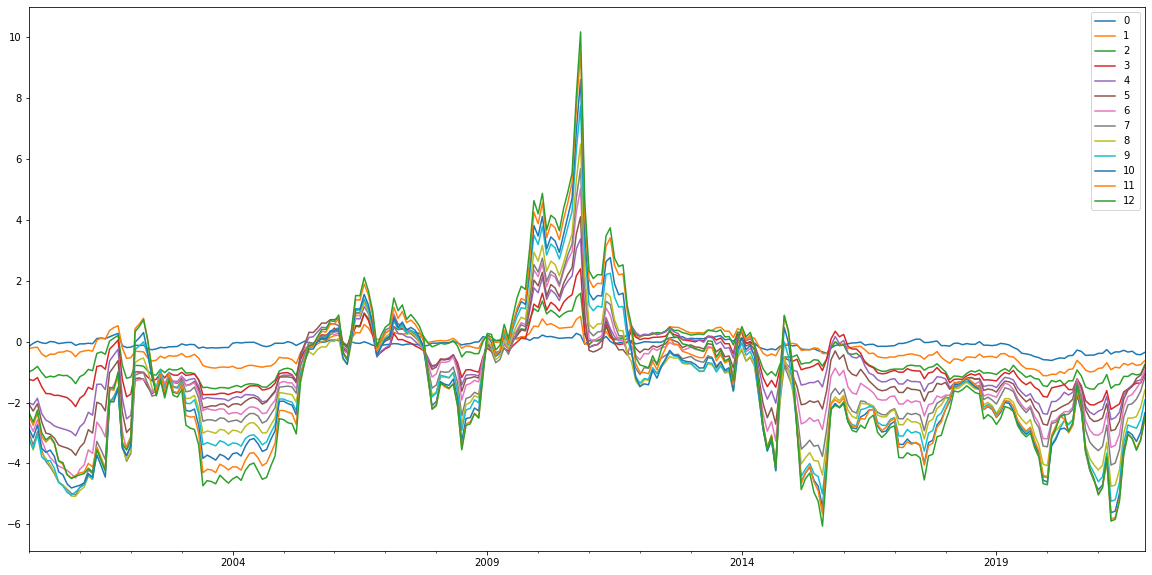

In [11]:
kf2.loc['2000':].plot(figsize=(20, 10))

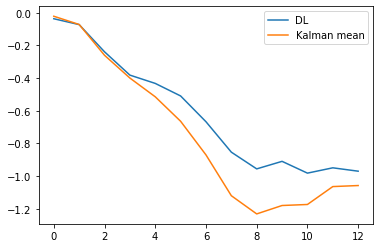

In [13]:
plt.plot(np.cumsum(DL('contract_1', 'GPRI', c1.join(gpr_shock).dropna()).model.params[1:]), label='DL')
plt.plot(kf2.mean(), label='Kalman mean')
plt.legend()